# Self-Supervised Learning and Anomaly Detection

This notebook guides you through an exercise to explore self-supervised learning and the impact of different pretext tasks on feature representations. You will train models with pretext tasks, fine-tune them for classification, and analyze their impact on fine-tuning.

**Exercises:**
1. One self-upservised pretext task is given, predicting rotation. Implement **one additional** pretext task. You can choose any traditional task or invent your own task.
2. Fine-tune the model by training it supervised to classify the images in the tiny Imagenet dataset.
3. Compare the performance
    - 3.1 Compare the performance **without** pre-training on a pretext task
    - 3.2 Compare the performance of both pre-training methods, the random rotation and the custom pretext task you implemented

In [ ]:
!pip install torch torchvision torchaudio matplotlib scikit-learn tqdm

In [1]:
import torch
torch.__version__

'2.5.0+cu121'

In [33]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
device

'cuda'

In [3]:
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

In [4]:
import urllib.request
import os
def download(url, filename):
    # download with check if file exists already
    if os.path.isfile(filename):
        return
    urllib.request.urlretrieve(url,filename)

In [5]:
from zipfile import ZipFile
def unzip(filename, dest_path = None):
    # unzips a zip file in the folder of the notebook to the notebook
    with ZipFile(filename, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. a
        if dest_path is None:
            zObject.extractall(path=os.getcwd())
        else:
            zObject.extractall(path=dest_path)

In [6]:
download('http://cs231n.stanford.edu/tiny-imagenet-200.zip','tiny-imagenet-200.zip')

In [7]:
# Note. Change this for non-linux students
#download('https://huggingface.co/datasets/zh-plus/tiny-imagenet/raw/main/classes.py','classes.py')

#download('https://huggingface.co/datasets/zh-plus/tiny-imagenet/resolve/main/classes.py','classes.py')
download('https://cloud.minesparis.psl.eu/index.php/s/nhODnzDi1lI11xD/download','classes.py')
#download('http://cs231n.stanford.edu/tiny-imagenet-200.zip','tiny-imagenet-200.zip')
#download('https://cloud.minesparis.psl.eu/index.php/s/MH70voh4vszUV5f/download','tiny-imagenet-200.zip')


In [8]:
unzip('tiny-imagenet-200.zip')

In [9]:
from classes import i2d

In [10]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import copy
import pandas as pd

class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir, transform=None, annotation_file=None):
        # If annotation file is present, take that as labels. Otherwise use path to infer. This will fail for validation files.
        
        self.paths = list(Path(targ_dir).glob("**/*.JPEG")) # tiny image net is a bit weird in its endings
        self.transform = transform
        if annotation_file is None:
            self.labels = list(map(self.get_label_from_path, self.paths))
        else:
            print('Load annotations from file')
            self.labels = self.get_labels_from_file(annotation_file)
            self.labels = [self.labels[label] for label in [os.path.basename(path) for path in self.paths]]
        
        self.label_names = copy.deepcopy(self.labels) # Keep original label names for later lookup
            
        # Converting label names to category numbers
        self.label_dict = dict(zip(np.unique(sorted(self.labels)),range(len(sorted(self.labels))))) # for faster lookup
        self.labels = [self.label_dict[label] for label in self.labels]            
        
    def get_labels_from_file(self, annotation_file):
        anns = pd.read_csv(annotation_file,sep='\t',names=['filename','label','x1','y1','x2','y2'])
        labels = dict(anns[['filename','label']].values)
        return labels
        
    @staticmethod
    def get_label_from_path(path):
        # returns the label from the path. Should return a number like n02403003 to be looked up in the classes.py
        # If something else is returned, there is probably an error on how the path is split here
        return str(path.with_suffix('')).split('images')[0].split(os.path.sep)[-2]
        
    def load_image(self, index):
        image_path = self.paths[index]
        img = Image.open(image_path).convert('RGB')
        # There are some outlier images which are actually gray.
        #if img.shape[0] == 1:
        #    img = img.convert('RGB')
        return img

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        label = self.labels[index]

        if self.transform:
            return self.transform(img), label
        else:
            return img, label        

In [11]:
batch_size = 32

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load Tiny ImageNet dataset
train_dataset = ImageFolderCustom('./tiny-imagenet-200/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # drop last drops the last batch which can have less instances than the batchsize and therefore lead to torch trying to stack vectors of unequal sizes. For training this is not important because the last batch will be, with shuffling, always contain different instances.

val_dataset = ImageFolderCustom('./tiny-imagenet-200/val/', transform=transform, annotation_file='./tiny-imagenet-200/val/val_annotations.txt')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Load annotations from file
Train dataset size: 100000
Validation dataset size: 10000


# Examples of an image from the training set and how to get its human readable label

'fly'

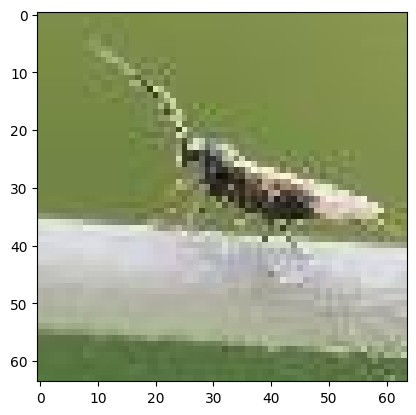

In [13]:
img, class_idx = next(iter(train_dataset))
plt.imshow(img.transpose(0,1).transpose(1,2).numpy())
class_id = train_dataset.label_names[61]
i2d[class_id] # translate class_id to readable name

## Same for one image from the validation set

'fly'

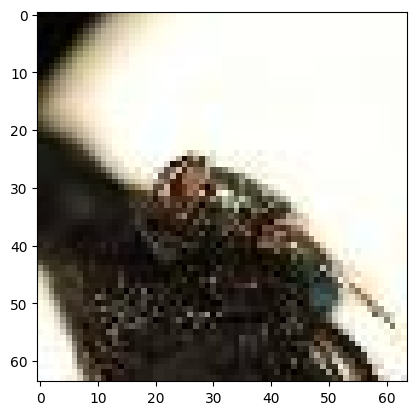

In [14]:
img, class_idx = next(iter(val_dataset))
plt.imshow(img.transpose(0,1).transpose(1,2).numpy())
class_id = list(val_dataset.label_dict.keys())[class_idx] # Important: Note the different way of resolving the label for the validation set
i2d[class_id]

## 1. Implement a Self-Supervised Pretext Task

Take a look how the image rotation prediction task is implemented and add one additional task

In [15]:
from torch.optim import Adam, SGD

In [24]:
def get_rot_mat(theta):
    #theta = torch.tensor(theta)
    rot_mats = torch.stack([torch.stack([torch.cos(theta), -torch.sin(theta), torch.zeros_like(theta)],dim=1),
             torch.stack([torch.sin(theta), torch.cos(theta), torch.zeros_like(theta)],dim=1)],dim=1)    
    return rot_mats

def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)
    grid = F.affine_grid(rot_mat, x.size(),align_corners=False)
    x = F.grid_sample(x, grid,align_corners=False)
    return x

In [17]:
from tqdm import tqdm

In [21]:
# Define the pretext model (e.g., rotation prediction)
class RotationPredictionModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.fc = nn.Linear(512, 4)  # 4 classes for rotation (0, 90, 180, 270)

    def forward(self, x):
        features = self.base_model(x)
        return self.fc(features)

# Example training loop
def train_pretext_model(model, dataloader, optimizer, criterion, epochs=5, start_epoch=0):
    model.train()
    for epoch in range(epochs):
        for images, _ in tqdm(dataloader):
            # Simulate rotations and labels here
            optimizer.zero_grad()

            images = images.to(device)

            # create |batch| random ints between 0 and 3
            # rotate images accordingly
            # use ints as label
            labels = torch.randint(4,(images.shape[0],)).to(device) # batch dimension
            rotated_im = rot_img(images, labels*np.pi/2,dtype=torch.FloatTensor) # Rotate image by random increments of 90 deg

            outputs = model(rotated_im)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1+start_epoch}, Loss: {loss.item():.4f}")

In [19]:
# Example training loop
def val_pretext_model(model, dataloader):
    model.eval()

    predictions = []
    all_labels = []
    
    for images, _ in tqdm(dataloader):
        images = images.to(device)

        labels = torch.randint(4,(images.shape[0],)).to(device) # batch dimension
        rotated_im = rot_img(images, labels*np.pi/2,dtype=torch.FloatTensor) # Rotate image by random increments of 90 deg
        
        outputs = model(rotated_im)
        
        predictions.extend(torch.argmax(outputs,dim=1).cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())

    return predictions, all_labels

## The loaded base model in this case is a resnet18. Depending on your computer you can change this to a better one

In [20]:
#base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
download('https://cloud.minesparis.psl.eu/index.php/s/qPecgC3E68I0CVn/download','pytorch-vision-v0.10.0-0-g300a8a4.zip')
unzip('pytorch-vision-v0.10.0-0-g300a8a4.zip')
base_model = torch.hub.load('pytorch-vision-300a8a4',  model="resnet18", trust_repo=True, source='local', weights=None)
base_model.fc = nn.Sequential()
_ = base_model.to(device)

In [22]:
rot_model = RotationPredictionModel(base_model).to(device)

In [23]:
# Hyperparameters
learning_rate = 0.0001
epochs = 1

# Loss function and optimizer
optimizer = Adam(rot_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

## Pretext task training loop

In [25]:
old_val = 0
n = 1
for i in range(n): # train n times and after the set amount of epochs check accuracy and save the model if better
    train_pretext_model(rot_model,train_loader,optimizer,criterion, epochs=epochs, start_epoch=i*n)
    train_predictions, all_labels = val_pretext_model(rot_model.to(device),train_loader)
    train_accuracy = np.sum(np.array(train_predictions) == np.array(all_labels)) / (len(train_loader)*batch_size)
    print('Train accuracy: ',train_accuracy)
    predictions, all_labels = val_pretext_model(rot_model.to(device),val_loader)
    val_accuracy = np.sum(np.array(predictions) == np.array(all_labels)) / (len(val_loader)*batch_size)
    print('Val accuracy: ',val_accuracy)
    if val_accuracy < old_val:
        print('Early stopping criteria reached')
        break
    else:
        torch.save(rot_model.state_dict(), 'checkpoint.pth')
        old_val = val_accuracy

100%|██████████| 3125/3125 [01:43<00:00, 30.26it/s]


Epoch 1, Loss: 1.1310


100%|██████████| 3125/3125 [00:46<00:00, 67.79it/s]


Train accuracy:  0.47783


100%|██████████| 313/313 [00:08<00:00, 36.25it/s]


Val accuracy:  0.46515575079872207


## These are helper methods to help you evaluate the results

In [26]:
def plot_confusion_matrix(_labels, _predictions, show_text_counts=True):    
    conf_matrix = confusion_matrix(y_true=_labels, y_pred=_predictions)
    
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    if show_text_counts:
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
     
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [27]:
# Example training loop
def show_examples(model, dataloader, n=5):
    model.eval()

    images = [dataloader.dataset.__getitem__(i)[0] for i in np.random.randint(0,len(dataloader),n)]
    
    for image in images:
        image = image.to(device) 

        labels = torch.randint(4,(1,)).to(device) # batch dimension
        rotated_im = rot_img(image.unsqueeze(0), labels*np.pi/2,dtype=torch.FloatTensor) # Rotate image by random increments of 90 deg
        
        outputs = model(rotated_im)
        
        plt.imshow(image.cpu().permute(1,2,0)) 
        plt.show()
        plt.imshow(rotated_im.cpu().squeeze(0).permute(1,2,0))
        plt.show()
        print(f'Label: {labels.cpu().numpy()} vs Prediction: {torch.argmax(outputs,dim=1).cpu().detach().numpy()}')

## After training the best checkpoint saved is loaded. This is not necessary but is useful code if you want to work on this in several sessions

In [28]:
rot_model.load_state_dict(torch.load('./checkpoint.pth', weights_only=True))
_ = rot_model.eval()

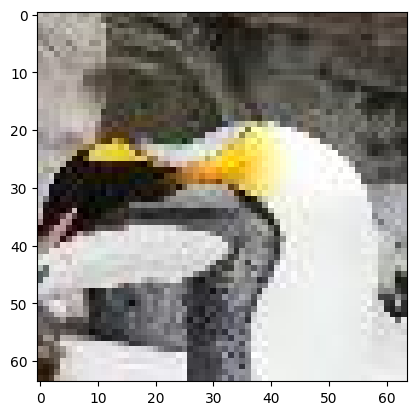

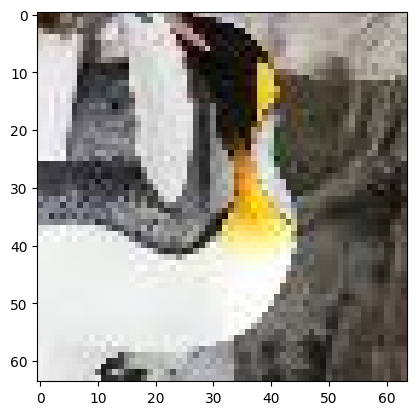

Label: [3] vs Prediction: [2]


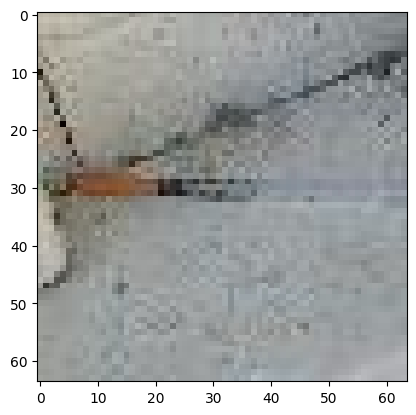

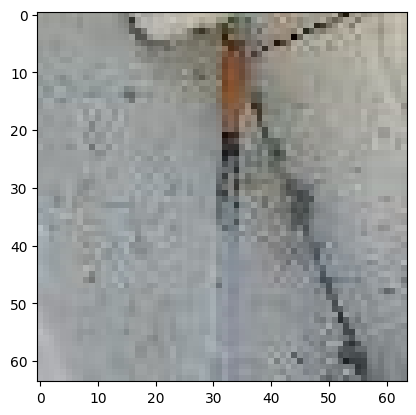

Label: [3] vs Prediction: [1]


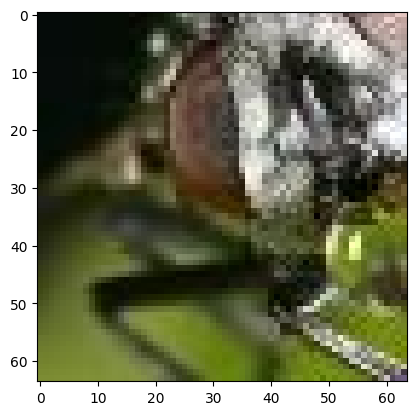

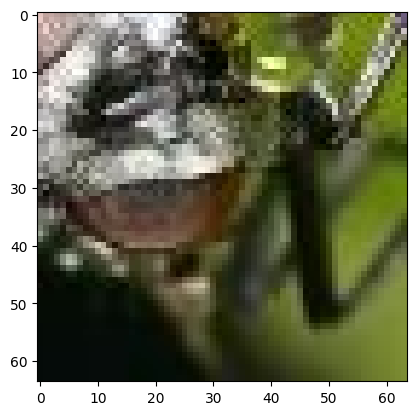

Label: [1] vs Prediction: [2]


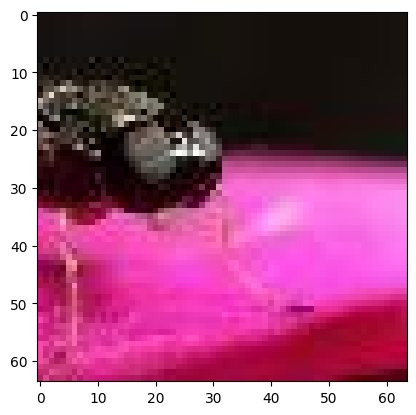

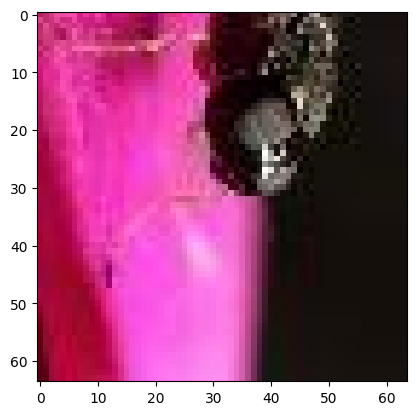

Label: [3] vs Prediction: [3]


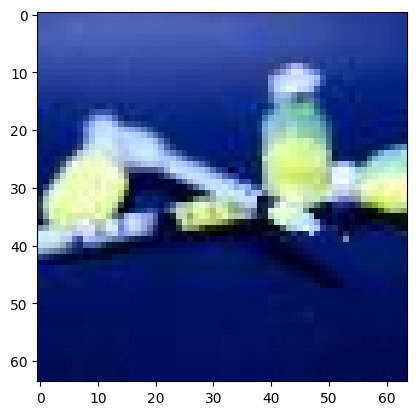

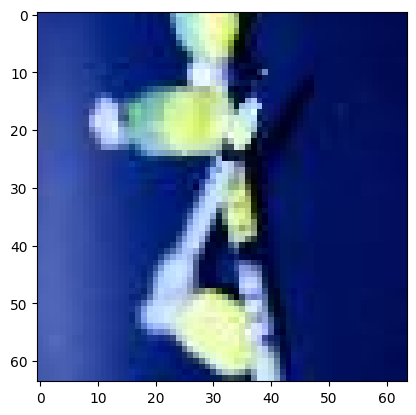

Label: [1] vs Prediction: [1]


In [29]:
show_examples(rot_model.to(device),train_loader)

## Get prediction for the validation set for the confusion matrix

In [30]:
val_predictions, val_labels = val_pretext_model(rot_model, val_loader)

100%|██████████| 313/313 [00:08<00:00, 39.07it/s]


## Check the confusion matrix

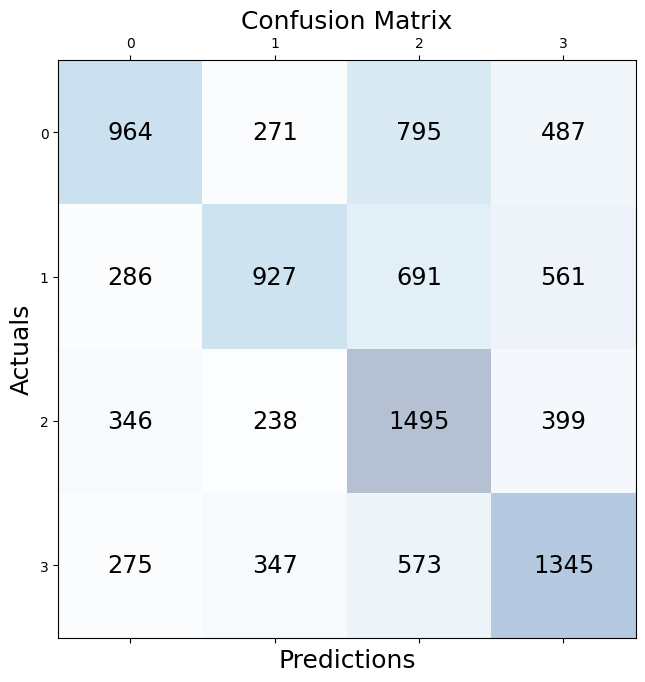

In [31]:
plot_confusion_matrix(val_labels, val_predictions)

## Now you can implement your pretext task

In [43]:
# place for your code
epochs = 3
n = 100
for i in range(n): # train n times and after the set amount of epochs check accuracy and save the model if better
    train_pretext_model(rot_model,train_loader,optimizer,criterion, epochs=epochs, start_epoch=i*n)
    train_predictions, all_labels = val_pretext_model(rot_model.to(device),train_loader)
    train_accuracy = np.sum(np.array(train_predictions) == np.array(all_labels)) / (len(train_loader)*batch_size)
    print('Train accuracy: ',train_accuracy)
    predictions, all_labels = val_pretext_model(rot_model.to(device),val_loader)
    val_accuracy = np.sum(np.array(predictions) == np.array(all_labels)) / (len(val_loader)*batch_size)
    print('Val accuracy: ',val_accuracy)
    if val_accuracy < old_val:
        print('Early stopping criteria reached')
        break
    else:
        torch.save(rot_model.state_dict(), 'checkpoint.pth')
        old_val = val_accuracy

100%|██████████| 3125/3125 [00:51<00:00, 60.60it/s]


Epoch 1, Loss: 1.1107


100%|██████████| 3125/3125 [00:49<00:00, 63.01it/s]


Epoch 2, Loss: 0.3540


100%|██████████| 3125/3125 [00:49<00:00, 62.98it/s]


Epoch 3, Loss: 0.4601


100%|██████████| 3125/3125 [00:40<00:00, 77.04it/s]


Train accuracy:  0.72356


100%|██████████| 313/313 [00:04<00:00, 72.69it/s]

Val accuracy:  0.6981829073482428
Early stopping criteria reached


100%|██████████| 313/313 [00:03<00:00, 88.76it/s] 


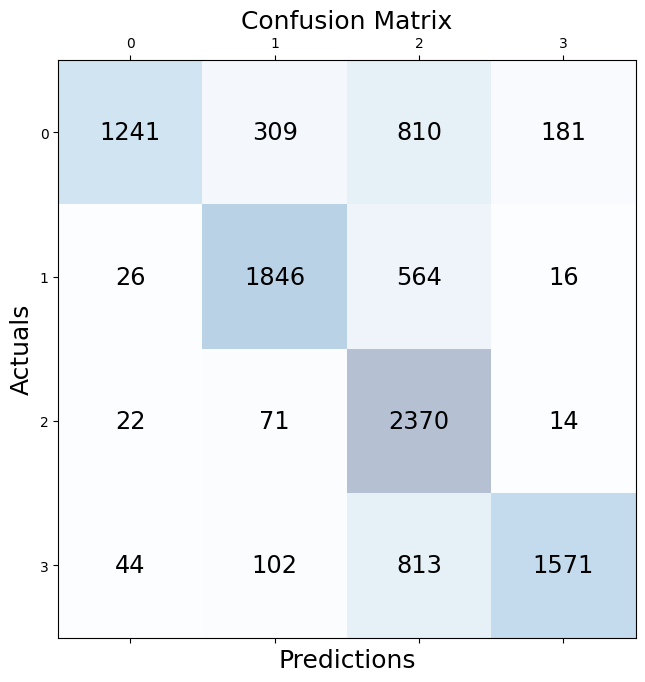

In [44]:
val_predictions, val_labels = val_pretext_model(rot_model, val_loader)
plot_confusion_matrix(val_labels, val_predictions)

## 3. Fine-Tune for Classification
Use the pre-trained model and fine-tune it for a classification task on Tiny ImageNet. In the following you find one example how to add one simple fully connected layer with Pytorch. You can add more complex additional classification heads as well. Note that they output the dimension 200 because tiny Imagenet has 200 classes.

In [66]:
class DownstreamModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.fc = nn.Linear(512, 200)

    def forward(self, x):
        features = self.base_model(x)
        return self.fc(features)

In [46]:
# Initialize the DownstreamModel with rot_model
downstream_model = DownstreamModel(rot_model.base_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(downstream_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    downstream_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Validation step
    downstream_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = downstream_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 3.5303, Accuracy: 25.00%
Epoch [2/10], Loss: 2.0581, Accuracy: 24.41%
Epoch [3/10], Loss: 1.5025, Accuracy: 28.48%
Epoch [4/10], Loss: 1.1565, Accuracy: 27.82%
Epoch [5/10], Loss: 0.9143, Accuracy: 27.47%
Epoch [6/10], Loss: 0.7399, Accuracy: 26.50%
Epoch [7/10], Loss: 0.6211, Accuracy: 27.15%
Epoch [8/10], Loss: 0.5281, Accuracy: 26.97%
Epoch [9/10], Loss: 0.4734, Accuracy: 27.69%
Epoch [10/10], Loss: 0.4220, Accuracy: 27.09%


Epoch [1/10], Loss: 1.4440, Accuracy: 28.29%
Epoch [2/10], Loss: 0.3690, Accuracy: 28.33%
Epoch [3/10], Loss: 0.2584, Accuracy: 28.64%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from tqdm import tqdm

class SimCLRTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

train_dataset = ImageFolder('./tiny-imagenet-200/train/', transform=SimCLRTransform())
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)

class SimCLRModel(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLRModel, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Identity() 
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )
    
    def forward(self, x):
        features = self.base_model(x)
        return self.projection_head(features)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim_matrix = nn.functional.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim_matrix = sim_matrix / temperature

    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z.device)

    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    sim_matrix = sim_matrix[~mask].view(sim_matrix.shape[0], -1)

    positives = sim_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = sim_matrix[~labels.bool()].view(sim_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z.device)

    return nn.CrossEntropyLoss()(logits, labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = models.resnet18(pretrained=False)
model = SimCLRModel(base_model, out_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

def train_simclr(model, dataloader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (x_i, x_j), _ in tqdm(dataloader):
            x_i, x_j = x_i.to(device), x_j.to(device)
            
            optimizer.zero_grad()
            
            z_i = model(x_i)
            z_j = model(x_j)

            loss = nt_xent_loss(z_i, z_j)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

train_simclr(model, train_loader, optimizer, epochs=10)


100%|██████████| 390/390 [02:52<00:00,  2.26it/s]


Epoch [1/10], Loss: 5.3249


100%|██████████| 390/390 [02:32<00:00,  2.56it/s]


Epoch [2/10], Loss: 5.1102


100%|██████████| 390/390 [02:29<00:00,  2.61it/s]


Epoch [3/10], Loss: 5.0368


100%|██████████| 390/390 [02:30<00:00,  2.59it/s]


Epoch [4/10], Loss: 5.0004


100%|██████████| 390/390 [02:30<00:00,  2.60it/s]


Epoch [5/10], Loss: 4.9725


100%|██████████| 390/390 [02:30<00:00,  2.60it/s]


Epoch [6/10], Loss: 4.9509


100%|██████████| 390/390 [02:29<00:00,  2.61it/s]


Epoch [7/10], Loss: 4.9305


100%|██████████| 390/390 [02:30<00:00,  2.59it/s]


Epoch [8/10], Loss: 4.9115


100%|██████████| 390/390 [02:29<00:00,  2.61it/s]


Epoch [9/10], Loss: 4.8952


100%|██████████| 390/390 [02:29<00:00,  2.60it/s]

Epoch [10/10], Loss: 4.8863


In [64]:
import torch
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader
from tqdm import tqdm

# Function to compute precision
def compute_precision(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for (x_i, x_j), _ in tqdm(dataloader):
            x_i, x_j = x_i.to(device), x_j.to(device)

            # Get embeddings
            z_i = model(x_i)
            z_j = model(x_j)

            # Compute cosine similarity
            sim = nn.functional.cosine_similarity(z_i, z_j)

            # Predicted positives based on threshold
            predictions = (sim > threshold).cpu().numpy()

            # True labels (1 for positive pairs)
            labels = np.ones_like(predictions)

            all_predictions.extend(predictions)
            all_labels.extend(labels)

    precision = precision_score(all_labels, all_predictions)
    return precision

# Compute precision on the training set
precision = compute_precision(model, train_loader)
print(f"Precision on training set: {precision:.4f}")


100%|██████████| 390/390 [02:35<00:00,  2.50it/s]

Precision on training set: 1.0000


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Define transformations for classification
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load Tiny ImageNet dataset
train_dataset = ImageFolder('./tiny-imagenet-200/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)

val_dataset = ImageFolder('./tiny-imagenet-200/val/', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Define the Downstream Model
class DownstreamModel(nn.Module):
    def __init__(self, base_model):
        super(DownstreamModel, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(512, 200)  # 200 classes for Tiny ImageNet

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

# Initialize the DownstreamModel with the base model from SimCLR
base_model = models.resnet18(pretrained=False)
base_model.fc = nn.Identity()  # Remove the classification layer

# Load the pre-trained weights from SimCLR if available
# base_model.load_state_dict(torch.load('simclr_pretrained.pth'))

downstream_model = DownstreamModel(base_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(downstream_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    downstream_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Validation step
    downstream_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = downstream_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 390/390 [00:26<00:00, 14.63it/s]


Epoch [1/10], Loss: 4.7227, Accuracy: 0.63%


100%|██████████| 390/390 [00:26<00:00, 14.93it/s]


Epoch [2/10], Loss: 3.8893, Accuracy: 0.53%


 18%|█▊        | 71/390 [00:05<00:22, 14.15it/s]


KeyboardInterrupt: 

In [10]:
# !export PATH="/usr/local/cuda-11.8/bin:$PATH"
# !export CUDA_HOME="/usr/local/cuda-11.8"
# !export LD_LIBRARY_PATH="/usr/local/cuda-11.8/targets/x86_64-linux/lib:$LD_LIBRARY_PATH"
# !nvcc -V
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet18


# stage one ,unsupervised learning
class SimCLRStage1(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLRStage1, self).__init__()

        self.f = []
        for name, module in resnet18().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Linear(512, feature_dim)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


# stage two ,supervised learning
class SimCLRStage2(torch.nn.Module):
    def __init__(self, num_class):
        super(SimCLRStage2, self).__init__()
        # encoder
        self.f = SimCLRStage1().f
        # classifier
        self.fc = nn.Linear(512, num_class, bias=True)

        for param in self.f.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out


class Loss(torch.nn.Module):
    def __init__(self):
        super(Loss,self).__init__()

    def forward(self,out_1,out_2,batch_size,temperature=0.5):
        # 分母 ：X.X.T，再去掉对角线值，分析结果一行，可以看成它与除了这行外的其他行都进行了点积运算（包括out_1和out_2）,
        # 而每一行为一个batch的一个取值，即一个输入图像的特征表示，
        # 因此，X.X.T，再去掉对角线值表示，每个输入图像的特征与其所有输出特征（包括out_1和out_2）的点积，用点积来衡量相似性
        # 加上exp操作，该操作实际计算了分母
        # [2*B, D]
        out = torch.cat([out_1, out_2], dim=0)
        # [2*B, 2*B]
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
        # [2*B, 2*B-1]
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

        # 分子： *为对应位置相乘，也是点积
        # compute loss
        pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        # [2*B]
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
        return (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()


for name, module in resnet18().named_children():
    print(name,module)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [11]:
import os
from torchvision import transforms

use_gpu=True
gpu_name=0

pre_model=os.path.join('pth','model.pth')

save_path="pth"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])


In [12]:
# loaddataset.py
from torchvision.datasets import CIFAR10
from PIL import Image


class PreDataset(CIFAR10):
    def __getitem__(self, item):
        img,target=self.data[item],self.targets[item]
        img = Image.fromarray(img)

        if self.transform is not None:
            imgL = self.transform(img)
            imgR = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return imgL, imgR, target



train_data = PreDataset(root='dataset', train=True, transform=train_transform, download=True)
print(train_data[0])


Files already downloaded and verified
(tensor([[[-1.3241, -0.9752, -0.6457,  ...,  0.1879,  0.0910,  0.0716],
         [-1.8087, -1.3629, -0.8395,  ..., -0.6069, -0.6650, -0.6069],
         [-1.3241, -0.9364, -0.6069,  ..., -0.6844, -0.7038, -0.8783],
         ...,
         [ 0.5174,  0.4011,  0.2267,  ..., -0.2773, -1.7312, -1.6924],
         [ 0.4981,  0.5756,  0.6725,  ...,  0.1491, -1.1109, -1.2660],
         [ 0.4981,  0.7501,  1.0602,  ...,  0.9439, -0.1029, -0.5100]],

        [[-1.2972, -0.9432, -0.6089,  ...,  0.2368,  0.1384,  0.1188],
         [-1.7889, -1.3366, -0.8056,  ..., -0.5696, -0.6286, -0.5696],
         [-1.2972, -0.9039, -0.5696,  ..., -0.6482, -0.6679, -0.8449],
         ...,
         [ 0.5711,  0.4531,  0.2761,  ..., -0.2352, -1.7102, -1.6709],
         [ 0.5514,  0.6301,  0.7284,  ...,  0.1974, -1.0809, -1.2382],
         [ 0.5514,  0.8071,  1.1218,  ...,  1.0038, -0.0582, -0.4712]],

        [[-1.1093, -0.7581, -0.4264,  ...,  0.4125,  0.3149,  0.2954],
      

In [15]:
import torch
import torchvision.transforms as T

class Augment:
   """
   A stochastic data augmentation module
   Transforms any given data example randomly
   resulting in two correlated views of the same example,
   denoted x ̃i and x ̃j, which we consider as a positive pair.
   """

   def __init__(self, img_size, s=1):
       color_jitter = T.ColorJitter(
           0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
       )
       # 10% of the image
       blur = T.GaussianBlur((3, 3), (0.1, 2.0))

       self.train_transform = torch.nn.Sequential(
           T.RandomResizedCrop(size=img_size),
           T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
           T.RandomApply([color_jitter], p=0.8),
           T.RandomApply([blur], p=0.5),
           T.RandomGrayscale(p=0.2),
           # imagenet stats
           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       )

   def __call__(self, x):
       return self.train_transform(x), self.train_transform(x)

In [17]:
!pip install pytorch-lightning
!pip install lightning-bolts
import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.multiprocessing import cpu_count
import torchvision.transforms as T

def default(val, def_val):
    return def_val if val is None else val

def reproducibility(config):
    SEED = int(config.seed)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if (config.cuda):
        torch.cuda.manual_seed(SEED)


def device_as(t1, t2):
    """
    Moves t1 to the device of t2
    """
    return t1.to(t2.device)

# From https://github.com/PyTorchLightning/pytorch-lightning/issues/924
def weights_update(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f'Checkpoint {checkpoint_path} was loaded')
    return model


class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, img_size, s=1):
        color_jitter = T.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        # 10% of the image
        blur = T.GaussianBlur((3, 3), (0.1, 2.0))

        self.train_transform = T.Compose(
            [
            T.RandomResizedCrop(size=img_size),
            T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
            T.RandomApply([color_jitter], p=0.8),
            T.RandomApply([blur], p=0.5),
            T.RandomGrayscale(p=0.2),
            # imagenet stats
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )

        self.test_transform = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)



def get_stl_dataloader(batch_size, transform=None, split="unlabeled"):

    stl10 = STL10("./", split=split, transform=transform, download=True)
    return DataLoader(dataset=stl10, batch_size=batch_size, num_workers=cpu_count()//2)

import matplotlib.pyplot as plt

def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

    def calc_similarity_batch(self, a, b):
        representations = torch.cat([a, b], dim=0)
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss



  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-n

100%|██████████| 2.64G/2.64G [06:06<00:00, 7.19MB/s]  


Extracting ./stl10_binary.tar.gz to ./


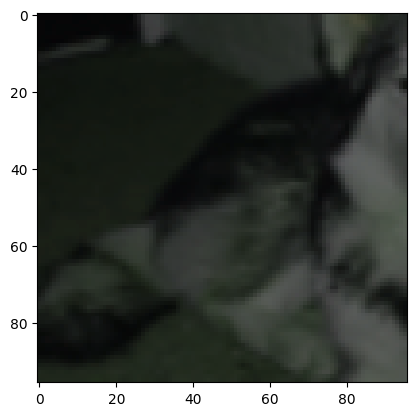

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


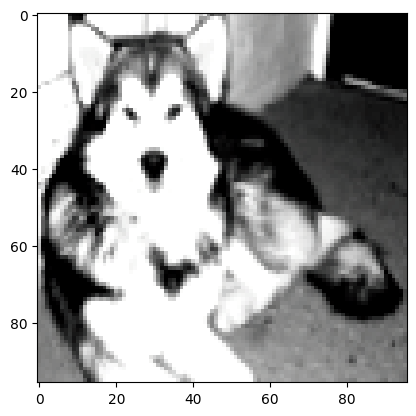

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


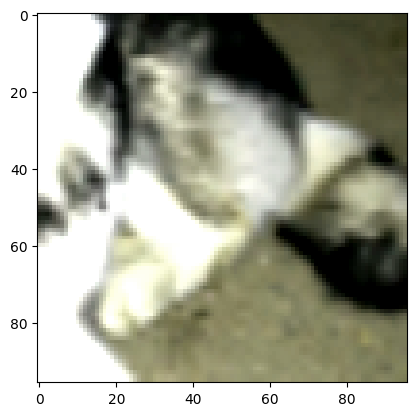

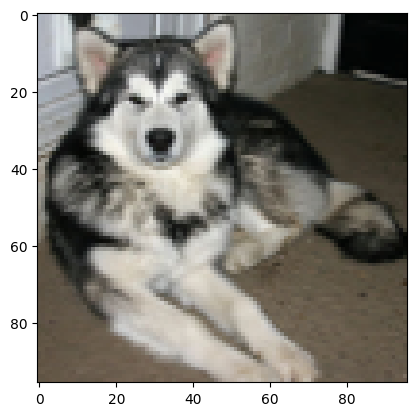

In [18]:
dataset = STL10("./", split='train', transform=Augment(96), download=True)
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])

In [19]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam


class AddProjection(nn.Module):
    def __init__(self, config, model=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = config.embedding_size
        self.backbone = default(model, models.resnet18(pretrained=False, num_classes=config.embedding_size))
        mlp_dim = default(mlp_dim, self.backbone.fc.in_features)
        print('Dim MLP input:',mlp_dim)
        self.backbone.fc = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
            nn.BatchNorm1d(mlp_dim),
            nn.ReLU(),
            nn.Linear(in_features=mlp_dim, out_features=embedding_size),
            nn.BatchNorm1d(embedding_size),
        )

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)



def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


class SimCLR_pl(pl.LightningModule):
    def __init__(self, config, model=None, feat_dim=512):
        super().__init__()
        self.config = config
        
        self.model = AddProjection(config, model=model, mlp_dim=feat_dim)

        self.loss = ContrastiveLoss(config.batch_size, temperature=self.config.temperature)

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        (x1, x2), labels = batch
        z1 = self.model(x1)
        z2 = self.model(x2)
        loss = self.loss(z1, z2)
        self.log('Contrastive loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        max_epochs = int(self.config.epochs)
        param_groups = define_param_groups(self.model, self.config.weight_decay, 'adam')
        lr = self.config.lr
        optimizer = Adam(param_groups, lr=lr, weight_decay=self.config.weight_decay)

        print(f'Optimizer Adam, '
              f'Learning Rate {lr}, '
              f'Effective batch size {self.config.batch_size * self.config.gradient_accumulation_steps}')

        scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,
                                                         warmup_start_lr=0.0)

        return [optimizer], [scheduler_warmup]

/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pl_

In [20]:
# a lazy way to pass the config file
class Hparams:
    def __init__(self):
        self.epochs = 300 # number of training epochs
        self.seed = 77777 # randomness seed
        self.cuda = True # use nvidia gpu
        self.img_size = 96 #image shape
        self.save = "./saved_models/" # save checkpoint
        self.load = False # load pretrained checkpoint
        self.gradient_accumulation_steps = 5 # gradient accumulation steps
        self.batch_size = 200
        self.lr = 3e-4 # for ADAm only
        self.weight_decay = 1e-6
        self.embedding_size= 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5
        self.checkpoint_path = './SimCLR_ResNet18.ckpt' # replace checkpoint path here

In [21]:
import torch
from pytorch_lightning import Trainer
import os
from pytorch_lightning.callbacks import GradientAccumulationScheduler
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models import  resnet18

available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
save_model_path = os.path.join(os.getcwd(), "saved_models/")
print('available_gpus:',available_gpus)
filename='SimCLR_ResNet18_adam_'
resume_from_checkpoint = False
train_config = Hparams()

reproducibility(train_config)

available_gpus: 1


In [23]:
model_pl = SimCLR_pl(train_config, model=resnet18(pretrained=False))
# model_pl = weights_update(model_pl, "SimCLR_ResNet18_adam_.ckpt")

resnet18_backbone_weights = model_pl.model.backbone
print(resnet18_backbone_weights)
torch.save({
            'model_state_dict': resnet18_backbone_weights.state_dict(),
            }, 'resnet18_backbone_weights.ckpt')

Dim MLP input: 512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [24]:
import pytorch_lightning as pl
import torch
from torch.optim import SGD


class SimCLR_eval(pl.LightningModule):
    def __init__(self, lr, model=None, linear_eval=False):
        super().__init__()
        self.lr = lr
        self.linear_eval = linear_eval
        if self.linear_eval:
          model.eval()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(512,10),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(0.1),
            # torch.nn.Linear(128, 10)
        )

        self.model = torch.nn.Sequential(
            model, self.mlp
        )
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss(z, y)
        self.log('Cross Entropy loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        predicted = z.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        self.log('Train Acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss(z, y)
        self.log('Val CE loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        predicted = z.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        self.log('Val Accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        if self.linear_eval:
          print(f"\n\n Attention! Linear evaluation \n")
          optimizer = SGD(self.mlp.parameters(), lr=self.lr, momentum=0.9)
        else:
          optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        return [optimizer]


class Hparams:
    def __init__(self):
        self.epochs = 100 # number of training epochs
        self.seed = 77777 # randomness seed
        self.cuda = True # use nvidia gpu
        self.img_size = 96 #image shape
        self.save = "./saved_models/" # save checkpoint
        self.gradient_accumulation_steps = 1 # gradient accumulation steps
        self.batch_size = 128
        self.lr = 1e-3 
        self.embedding_size= 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5

import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import GradientAccumulationScheduler
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models import resnet18


# general stuff
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
train_config = Hparams()
save_model_path = os.path.join(os.getcwd(), "saved_models/")
print('available_gpus:', available_gpus)
filename = 'SimCLR_ResNet18_finetune_'
reproducibility(train_config)
save_name = filename + '_Final.ckpt'

# load resnet backbone
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Identity()
checkpoint = torch.load('resnet18_backbone_weights.ckpt')
backbone.load_state_dict(checkpoint['model_state_dict'])
model = SimCLR_eval(train_config.lr, model=backbone, linear_eval=False)

# preprocessing and data loaders
transform_preprocess = Augment(train_config.img_size).test_transform
data_loader = get_stl_dataloader(train_config.batch_size, transform=transform_preprocess,split='train')
data_loader_test = get_stl_dataloader(train_config.batch_size, transform=transform_preprocess,split='test')


# callbacks and trainer
accumulator = GradientAccumulationScheduler(scheduling={0: train_config.gradient_accumulation_steps})

checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path,save_last=True,save_top_k=2,
                                       monitor='Val Accuracy_epoch', mode='max')

trainer = Trainer(callbacks=[checkpoint_callback,accumulator],
                  gpus=available_gpus,
                  max_epochs=train_config.epochs)

trainer.fit(model, data_loader,data_loader_test)
trainer.save_checkpoint(save_name)


available_gpus: 1


/tmp/ipykernel_19668/3887103939.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet18_backbone_weights.ckpt')


Files already downloaded and verified


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/julyfun/Documents/GitHub/speit-ml-tp/lightning_logs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | mlp   | Sequential       | 5.1 K 
1 | model | Sequential       | 11.2 M
2 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
2024-11-27 11:49:23.104752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 11:49:23.400583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732679363.495488   19668 cuda_dnn.cc:8310] Unable to register cuDNN fa

/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 103/103 [00:02<00:00, 36.53it/s, loss=0.00187, v_num=0, Cross Entropy loss_step=9.32e-5, Val Accuracy_step=0.500, Val Accuracy_epoch=0.509, Cross Entropy loss_epoch=0.00198, Train Acc=1.000] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 103/103 [00:03<00:00, 34.20it/s, loss=0.00187, v_num=0, Cross Entropy loss_step=9.32e-5, Val Accuracy_step=0.500, Val Accuracy_epoch=0.509, Cross Entropy loss_epoch=0.00198, Train Acc=1.000]


## 4. Evaluate the performance of your model doing classification 
- 4.1 Compare the performance **without** pre-training on a pretext task 
- 4.2 Compare the performance of both pre-training methods, the random rotation and the custom pretext task you implemented

In [25]:
# load model
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Identity()
print('imagenet weights, no pretraining')
model = SimCLR_eval(train_config.lr, model=resnet, linear_eval=False)

# preprocessing and data loaders
transform_preprocess = Augment(train_config.img_size).test_transform
data_loader = get_stl_dataloader(128, transform=transform_preprocess,split='train')
data_loader_test = get_stl_dataloader(128, transform=transform_preprocess,split='test')

checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path)

trainer = Trainer(callbacks=[checkpoint_callback],
                  gpus=available_gpus,
                  max_epochs=train_config.epochs)

trainer.fit(model, data_loader, data_loader_test)
trainer.save_checkpoint(save_name)

/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


imagenet weights, no pretraining
Files already downloaded and verified


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/julyf

Files already downloaded and verified
Epoch 99: 100%|██████████| 103/103 [00:02<00:00, 36.52it/s, loss=0.00183, v_num=1, Cross Entropy loss_step=5.5e-5, Val Accuracy_step=0.594, Val Accuracy_epoch=0.517, Cross Entropy loss_epoch=0.00192, Train Acc=1.000]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 103/103 [00:02<00:00, 34.35it/s, loss=0.00183, v_num=1, Cross Entropy loss_step=5.5e-5, Val Accuracy_step=0.594, Val Accuracy_epoch=0.517, Cross Entropy loss_epoch=0.00192, Train Acc=1.000]


## (Bonus exercise) 5. Visualize train and validation features of the trained model with a t-SNE

In [ ]:
# Example: Extract features from a trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model.base_model(images)  # Extract features
            features.append(outputs.cpu().numpy())
    return np.concatenate(features, axis=0)

features = extract_features(rot_model, val_loader)